# Risk assesment for Winstorms

Using this worflow you will learn more about how Windstorm damages can be assessed. 

## Risk assessment methodology.

This event-based windstorm risk workflow can be used to see damages of a storm by combining hazard, exposure and vulnerability. The workflow is a simplified version of the work by [Koks & Haer (2020)](https:/doi.org/10.1038/s41598-020-63580-w). Here the hazard is a map with the maximum 3-second wind gust of a storm. Exposure is determined by a map in which assets are associated with maximum damage that can occur per square meter of the asset and a certain exposure class is given to the asset. Vulnerability is defined as a collection of damage curves where the 3 second wind gusts are matched to a percentage of the asset that is damad

 When overlaying the sets, all assets contain information on the type of asset class it is, the maximum damage that can occur at the asset, the vulnerability curve of the asset, and the windspeed at the asset location. With this information, one can do the damage calculation per asset. Step one is to inspect the vulnerability curve and how much of the asset is destroyed by the wind speed. This results in a fraction of the maximum damage value that occurs. Multiplying the maximum damage by the found damaged fraction results in the damage estimation of that asset. Doing this calculation for all asset locations in the region results in a map of the most affected locations.


### Hazard data
Using the Copernicus Climate Data store, [historical storm footprints](https://doi.org/10.24381/cds.9b4ea013) can be retrieved. Next to that, [synthetic storms footprints](https://doi.org/10.24381/cds.ce973f02) can be found that are physically realistic and thus plausible storms. These synthetic storms can be useful to create a larger overview of possible events that can affect the area in current-day situations. Both datasets give the footprints of the maximum 3-second gust per 72 hours per grid cell.  

### Exposure data
An example dataset that can be used in this workflow is the [CORINE Land Cover data](https://land.copernicus.eu/pan-european/corine-land-cover). Be sure to download "CLC \[YYYY\]" for the year of interest in a raster type to be able to use this workflow as is.  With this dataset, the exposed asset is a 100x100m grid cell. Each land cover type is given a certain asset class that can be associated with the vulnerability curves. 

Each land cover type is also associated with a maximum damage per square meter. A first estimation of the maximum damages are based on [JRC maximum damage estimates](https://dx.doi.org/10.2760/16510) per country.

### Vulnerability data  
Each asset class is associated with a vulnerability curve. The vulnerability data consists of six curves determined by [Feuerstein et al. (2011)](https://doi.org/10.1016/j.atmosres.2010.12.026). The asset classes are differentiated by the type of building that are mainly present in the asset. These estimate damage curves can be found in the supplied material. 


## Preparation work

### Load libraries

In this notebook, we will use the following Python libraries:

::::{grid} 2 3 4 4

:::{card}
:header: [os](https://docs.python.org/3/library/os.html)
To create directories and work with files
:::

:::{card}
:header: [zipfile](https://docs.python.org/3/library/zipfile.html#zipfile-objects)
To download and unzip the data
:::

:::{card}
:header: [rasterio](https://rasterio.readthedocs.io/en/stable/)
To access and explore geospatial raster data in GeoTIFF format
:::

:::{card}
:header: [xarray](https://docs.xarray.dev/en/stable/)
To process the data and prepare it for damage calculation
:::

:::{card}
:header: [rioxarray](https://corteva.github.io/rioxarray/stable/)
Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
:::

:::{card}
:header: [damagescanner](https://damagescanner.readthedocs.io/en/latest/#)
To calculate the damage maps
:::


:::{card}
:header: [matplotlib](https://matplotlib.org/)
To plot results
:::
::::

:::{card}
:header: [numpy](https://numpy.org/) & [pandas](https://pandas.pydata.org/)
To work with and manipulate data
:::

:::{card}
:header: [cdsapi](https://cds.climate.copernicus.eu/api-how-to)
To download data from the Copernicus Data Store 
:::


In [161]:
import os
from zipfile import ZipFile
import rioxarray as rxr
import xarray as xr
from damagescanner.core import RasterScanner

import matplotlib.pyplot as plt

import cdsapi
import numpy as np
import pandas as pd


### Create the directory structure
In order for this workflow to work, we need to set up the directory structure. The next cell will create the directory called 'storm_event_raster' in the same directory where this notebook is saved.

In [162]:
workflow_folder = 'storm_event_raster'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(f"{workflow_folder}/data")

data_dir = os.path.join(workflow_folder,'data')

### Download data

In this part, we will ensure we have all the files we need to complete this workflow.

Note that now we have a directory **storm_event_raster/data** where all the files should be placed.

#### Hazard data
First we need the information on the hazard we want to analyse. In this workflow we will start by downloading a storm in Latvia from the historical [wind storm data set](https://doi.org/10.24381/cds.9b4ea013). In the "Download data" tab select "widstorm footprints" and select one of the available dates.

Alternativel, you can also use the code below and download the data using the API provided by the Climate Data Store. Be sure to register an account and obtain the userid and the api key to place below

In [163]:
uid = 1234
apikey = 'xxxxx'

c = cdsapi.Client(key=f"{uid}:{apikey}", url="https://cds.climate.copernicus.eu/api/v2")

# check if cds api key, uid, and request in general is valid
try:
    c.retrieve(
        'sis-european-wind-storm-indicators',
        {
            'variable': 'all',
            'format': 'zip',
            'product': 'windstorm_footprints',
            'year': '2013',
            'month': '10',
            'day': '28',
        },
        f'{data_dir}/storm.zip'
        )
except:
    print('Error: Check your uid and apikey and if the retrieve request contains the correct values.')

2023-07-19 14:54:00,938 INFO Welcome to the CDS
2023-07-19 14:54:00,939 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-european-wind-storm-indicators


Error: Check your uid and apikey and if the retrieve request contains the correct values.


### Exposure data
In this worflow we use the CORINE land cover data set. To log in you will need to create an account an download the raster data set from one of the available years. Click [here](https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=download) to go to 2018 data set. Within the retrieved folder copy the 'U2018_CLC2018_V2020_20u1.tif' file into the **storm_event_raster/data** folder.

### Vulnerability data
For this workflow initial maximum damages and damage curves are provided. However, these are just estimates and need to be adjusted according to the regional context to provide a valid damage estimations.

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

### Setting the region
First, we will set the region of interest through the use of a bounding box. This can be done by setting the corner coordinates of a self defined rectangle. See https://boundingbox.klokantech.com/ to get the bounding box of your area of interest and put the coordinates in the next cell (select csv in the copy-paste field at the bottom of the website window).


In [164]:
bbox = [23.5792,56.416,24.1312,56.8018] # [lon_min, lat_min, lon_max, lat_max]


### Hazard data

The dowloaded storm footprints can be visualised to get an overview of what it in the dataset. First, we need to open the storm footprint from the downloaded zipfile. Then we change the dimension from latitude and longitude to y and x so we can work with and manipulate the data later. Then, we need to set the CRS of the dataset since that has not be predefined by the Copernicus Climate Data Store. Before plotting we need to select the right variable to plot ('FX') and specify the band of interst, in this case there is only one so that is easy (z=1)

Text(0.5, 1.0, 'Windstorm across Europe')

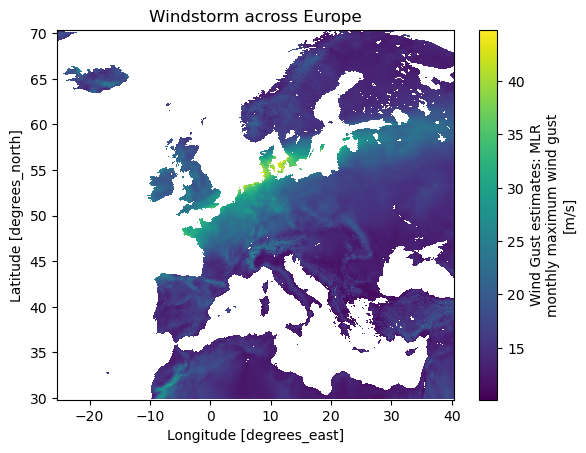

In [165]:
with ZipFile(f"{data_dir}/storm.zip") as zf:
    
    # Let's get the filename first
    file = zf.namelist()[0]
    
    # And now we can open and select the file within Python
    with zf.open(file) as f:
        windstorm_europe = xr.open_dataset(f)

windstorm_europe = windstorm_europe.rename({'Latitude': 'y','Longitude': 'x'})
windstorm_europe = windstorm_europe.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

windstorm_europe.rio.write_crs(4326, inplace=True)

windstorm_europe = windstorm_europe['FX']['z'==1]

#plot
windstorm_europe.plot()
plt.title('Windstorm across Europe')

In the plot above you can see the high windspeeds of the storm light up in yellow across Europe

### Exposure data

Next we analyse the exposure data. There are datasets to analyse. First, the downloaded landcover data and then the maximum damage per landcover class.

#### Land cover data

Using rioxarray, the lancover data is opened and the correct band is selected. In this case the band of interest is 1 (also the only band). Also for this dataset the crs needs to be written. From there we want to visualise the land cover map, however, since the land cover data has a detailed resolution (100mx100m) it takes a long time to plot all of Europe. That is why we clip the land use to the region of our bounding box before plotting. To match the colours on the Corine Land Cover data portal we define a set of colours to plot the data with.

Text(0.5, 1.0, 'Corine Land Cover 2018 for the defined area')

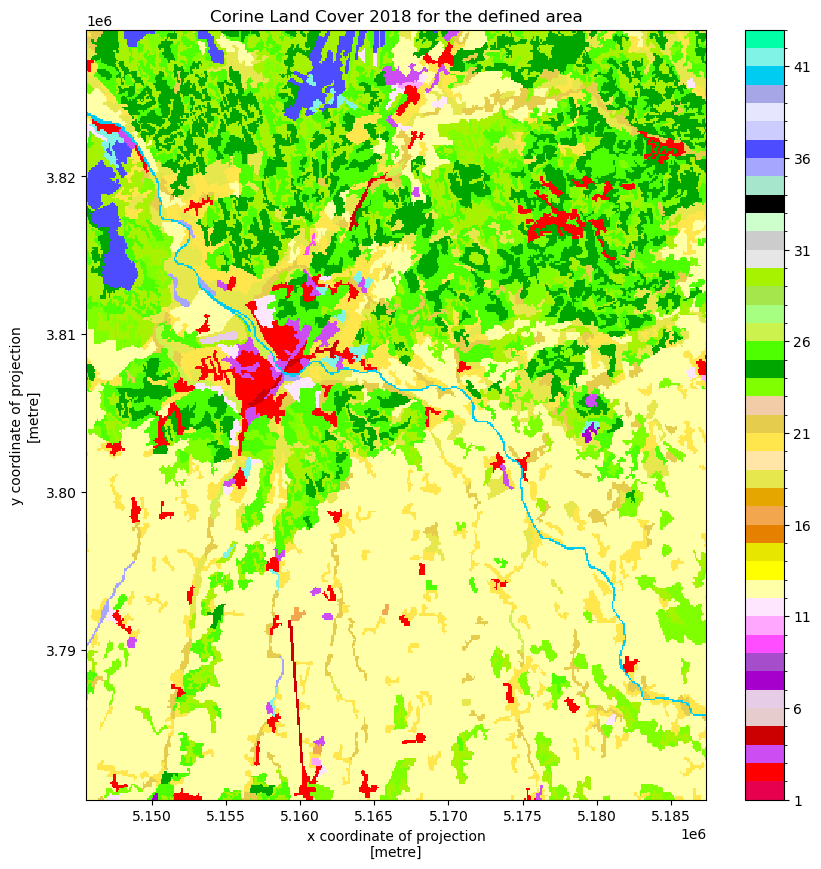

In [166]:
filename_land_use = f'{data_dir}/U2018_CLC2018_V2020_20u1.tif'
land_use = rxr.open_rasterio(filename_land_use)
land_use = land_use['band'==1]
land_use = land_use.drop(['band'])
land_use.rio.write_crs(3035, inplace=True)

land_use_test_plot = land_use.rio.clip_box(*bbox,
                                        crs="EPSG:4326")

CLC_values = np.arange(1,44)

CLC_colors = ['#E6004D', '#FF0000', '#CC4DF2', '#CC0000', '#E6CCCC', '#E6CCE6', '#A600CC', '#A64DCC', '#FF4DFF', '#FFA6FF', '#FFE6FF', '#FFFFA8', '#FFFF00', '#E6E600',
 '#E68000', '#F2A64D', '#E6A600', '#E6E64D', '#FFE6A6', '#FFE64D', '#E6CC4D', '#F2CCA6', '#80FF00', '#00A600',
 '#4DFF00', '#CCF24D', '#A6FF80', '#A6E64D', '#A6F200', '#E6E6E6', '#CCCCCC', '#CCFFCC', '#000000', '#A6E6CC',
 '#A6A6FF', '#4D4DFF', '#CCCCFF', '#E6E6FF', '#A6A6E6', '#00CCF2', '#80F2E6', '#00FFA6', '#A6FFE6', '#E6F2FF']


# plot the land use
land_use_test_plot.plot(levels=CLC_values, colors=CLC_colors, figsize=(10,10))
plt.title('Corine Land Cover 2018 for the defined area')

#### Maximum damage per land cover class

Next, we take a look a the maximum damage that can occur per land use class  [€/m²]. We only show the first 10 values, just to get an idea of what is in there. We see that there is quite a bit of variation in the type of landuse and the value that it has.

In [167]:
maxdam = pd.read_csv('maxdam.csv', index_col=0)
maxdam.head(10)

,damage
landuse,
1,50.0
2,1600.0
3,1000.0
4,20.0
5,50.0
6,1400.0
7,1000.0
8,2500.0
9,2000.0


### Vulnerability

Finaly, we inspect the vulnerability curves that we will use in the analysis. In the index we see that there is the windspeed associated with a land use class and a fraction of that land use class that is destroyed at that wind speed.

In [168]:
curves = pd.read_csv(f'curves.csv', index_col=0)
curves.head()

,1,2,3,4,5,6,7,8,9,10,...,35,36,37,38,39,40,41,42,43,44
1.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
3.58,0.1,0.05,0.05,0.1,0.1,0.05,0.05,0.05,0.05,0.05,...,0.028,0.028,0.028,0.028,0.028,0.028,0.1,0.2,0.2,0.2
6.16,0.2,0.09,0.09,0.2,0.2,0.09,0.09,0.09,0.09,0.09,...,0.056,0.056,0.056,0.056,0.056,0.056,0.2,0.4,0.4,0.4
8.74,0.3,0.12,0.12,0.3,0.3,0.12,0.12,0.12,0.12,0.12,...,0.084,0.084,0.084,0.084,0.084,0.084,0.3,0.6,0.6,0.6
11.32,0.4,0.15,0.15,0.4,0.4,0.15,0.15,0.15,0.15,0.15,...,0.112,0.112,0.112,0.112,0.112,0.112,0.4,0.8,0.8,0.8


Plotting the curves makes the damage functions more insight full. Steep curves indicate a quick change in damage with only a small change in wind speed. Flat curves indicate a small change in damage with a large change in wind speed and are therefore more resillient to high windspeeds.

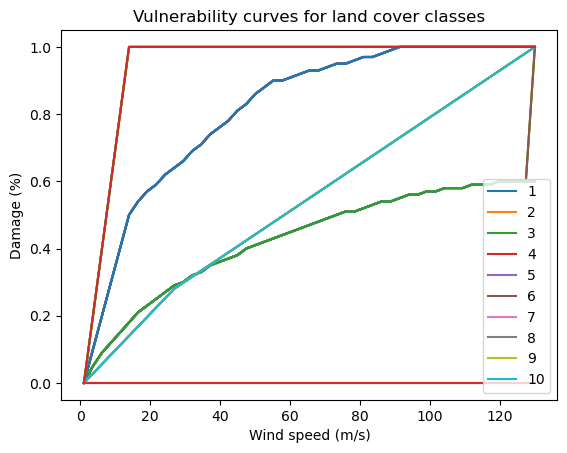

In [169]:
curves = pd.read_csv(f'curves.csv', index_col=0)

curves.plot()
plt.title('Vulnerability curves for land cover classes')
plt.ylabel('Damage (%)')
plt.xlabel('Wind speed (m/s)')

# only show legend for the first 10 entries
plt.legend(curves.columns[:10], loc='lower right')

## Process the data

In this section we will first process the data before we do our damage calculations. This is needed since the windspeed map and land cover map have different resolutions and projections meaning they do not match when we overlay them directly. 

## Clipping to the region

Before we calculate for the whole of Europe (meaning a lot of calculation time) we snip the datasets to our region of interest.

### Hazard

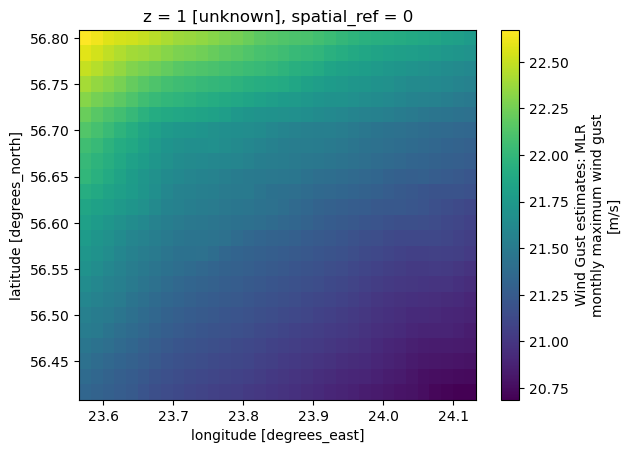

In [170]:
windstorm_region = windstorm_europe.rio.clip_box(*bbox, 
                                                 crs=4326)


windstorm_region.plot()

### Exposure

Since the land use data is in a different projection, we need to reproject the land use data to that of our bounding box (EPSG:4326) before we can clip the dataset to our region of interest.

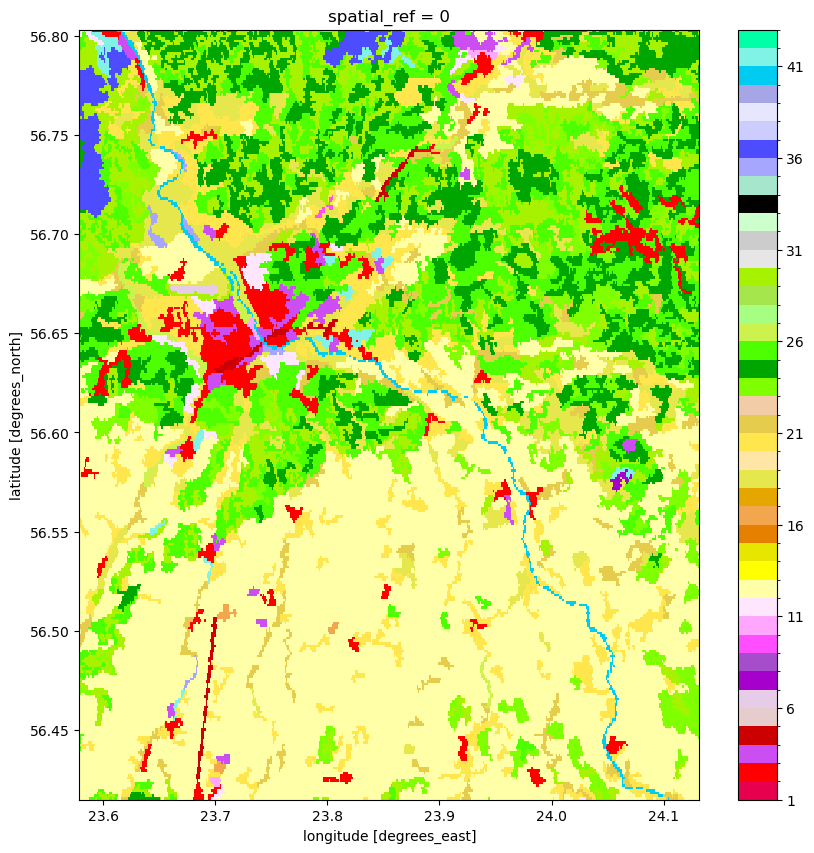

In [171]:
land_use = land_use.rio.reproject("EPSG:4326")

# clip land use to the same extent as the windstorm
land_use_region = land_use.rio.clip_box(*bbox,
                                        crs="EPSG:4326")

# Only keep values higher than 0 (no data)
land_use_region = land_use_region.where(land_use_region > 0)
land_use_region.plot(levels=CLC_values, colors=CLC_colors, figsize=(10,10))

Now that we have our region of interst for the land cover. It is also interesting to see the damage potential in the region due to high wind speeds.

Text(0.5, 1.0, 'Damage potential in the region based on land use and maxdamages')

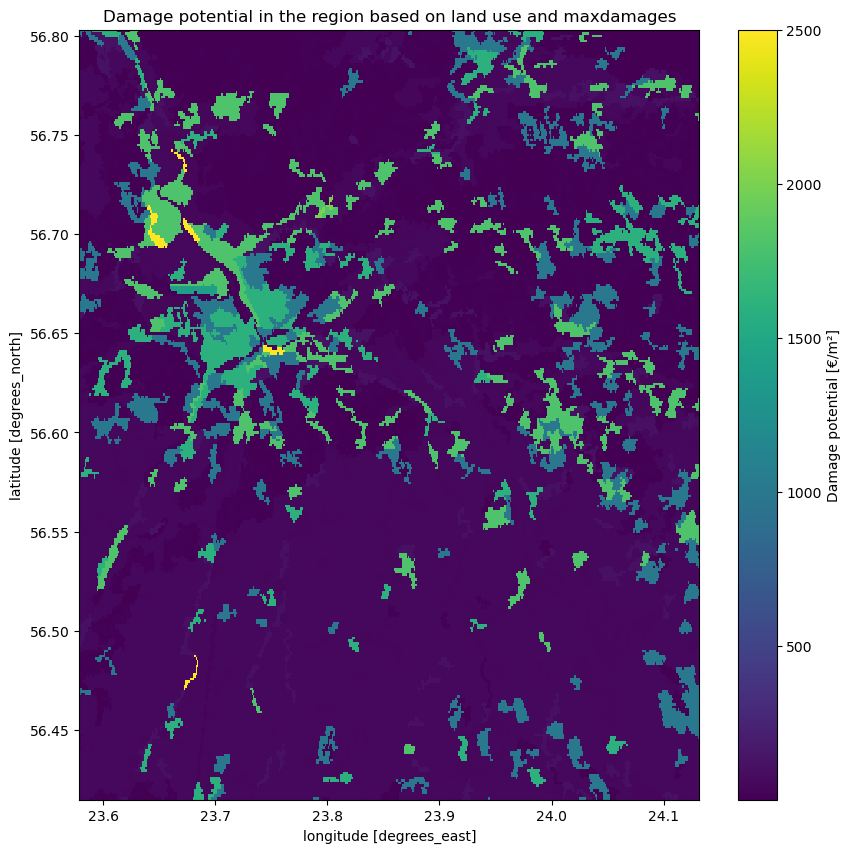

In [172]:
# assign each land use class a maxdamage value and plot this on the map
maxdam_map = land_use_region
for i in range(1,44):
    maxdam_map = maxdam_map.where(land_use_region != i, maxdam['damage'][i])
maxdam_map.plot(figsize=(10,10), cbar_kwargs={'label': "Damage potential [€/m²]"})
plt.title('Damage potential in the region based on land use and maxdamages')


### Matching the two layers

Now that the two datasets are in the same CRS, we can increase the resoltution of the windmap to match that of the land cover map. When increasing the resolution we need to do something with the added datapoints in our map. We can either fill these new datapoints in with whatever valaue is nearest in the orignal data set or we can interpolate the data. Choose something that makes sense. For wind data it is more logical to interpolate since abrupt changes along an arbitrary line of pixels is unlikely. However, for land use data it might make sense to choose the nearest datapoint. Otherwise the interpolation method will create new land use classes, which will be void of meaning. For example, on the edge between land use class 10 and 11 it will create 10.5 or between class 1 and 10 it will set pixels to 5 without the pixel actually being class 5.

Text(0.5, 1.0, 'Windstorm data matched to land use data')

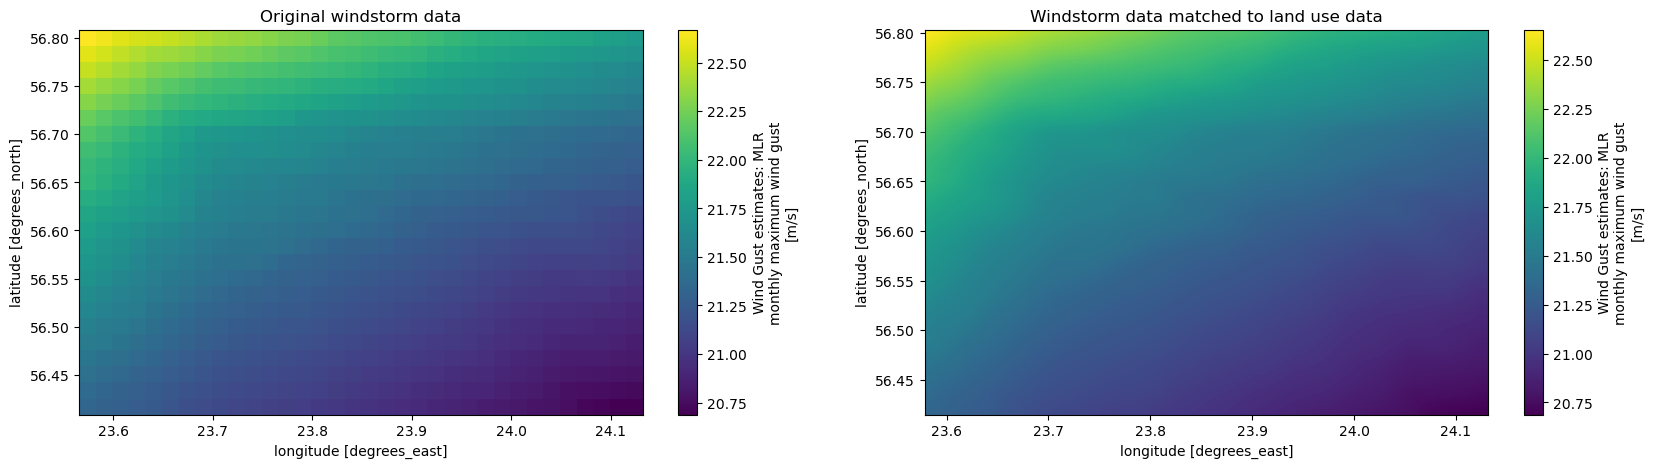

In [173]:
from rasterio.enums import Resampling

windstorm_region_matched = windstorm_region.rio.reproject_match(land_use_region, resampling= Resampling.cubic) # can also be .nearest or


windstorm_region_matched = windstorm_region_matched.assign_coords({
    "x": land_use_region.x,
    "y": land_use_region.y,
})


# plot windstorm_region and windstorm_region_matched next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

windstorm_region.plot(ax=ax1)
ax1.set_title("Original windstorm data")

windstorm_region_matched.plot(ax=ax2)
ax2.set_title("Windstorm data matched to land use data")


Now we can overlay the two images to get a quick look at where high windspeeds are and where certain land cover classes are.

Text(0.5, 1.0, 'Windstorm and land use 2018')

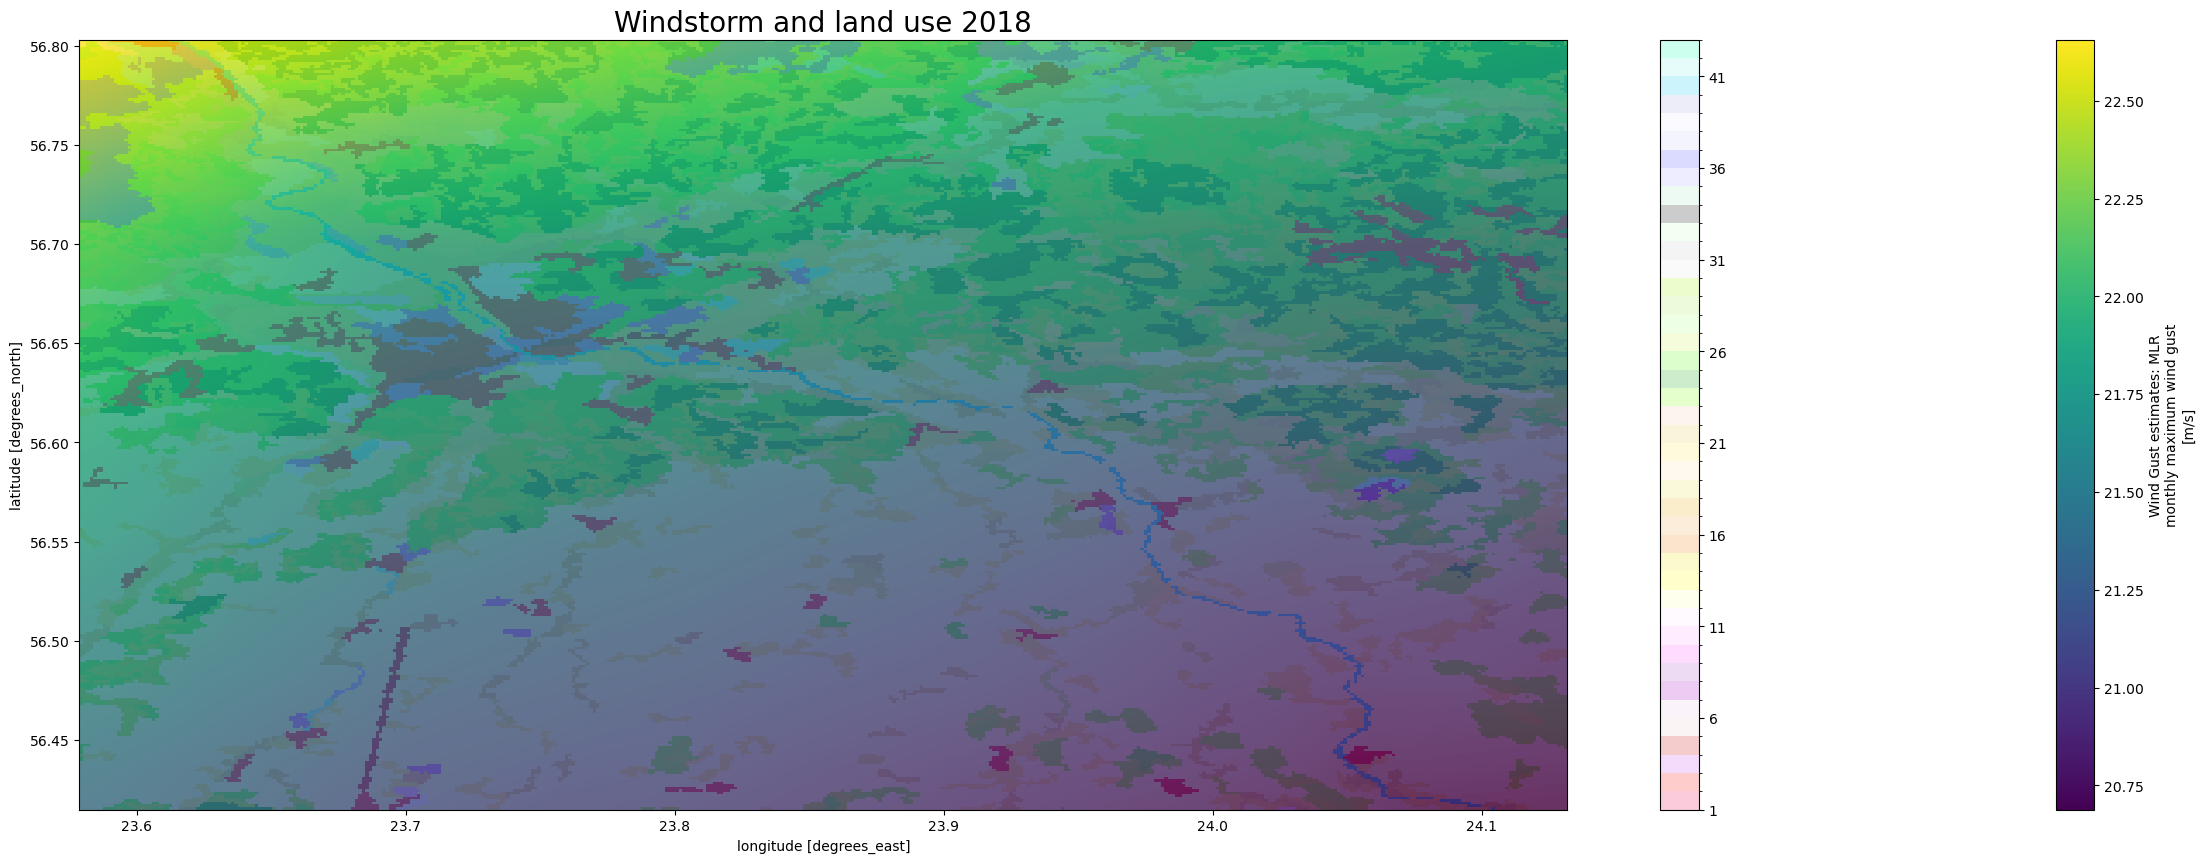

In [174]:
# plot
fig, ax = plt.subplots(figsize=(30, 10))
windstorm_region_matched.plot(ax=ax, cmap='viridis', alpha=1)
land_use_region.plot(ax=ax, levels=CLC_values, colors=CLC_colors, alpha=0.2)
ax.set_title('Windstorm and land use 2018', fontsize=20)

Because the used DamageScanner package uses the resolution of the maps to calculate the area in m² it is necessarry to convert the used CRS to one that uses meters instead of degrees. 

In [175]:
# set the correct order of the coordinates in the data set
windstorm_region_matched.transpose('y', 'x')
land_use_region=land_use_region.transpose('y', 'x')

# reproject to a CRS in meters
windstorm_region_matched = windstorm_region_matched.rio.reproject(3857)
land_use_region = land_use_region.rio.reproject(3857)

## Calculate the indices

Now that we have everything ready, we can do the damage calculation using the RasterScanner function from the DamageScanner python package. Making the 

In [176]:
# code for the calculation
curve_path = os.path.join(data_dir,'curves.csv')
maxdam_path = os.path.join(data_dir,'maxdam.csv')

damage_catagory, damage_map, _, _ = RasterScanner(  landuse_file = land_use_region,
                                                    hazard_file = windstorm_region_matched,
                                                    curve_path = curve_path,
                                                    maxdam_path = maxdam_path,
                                                    scenario_name='test_storm',
                                                    lu_crs=land_use_region.rio.crs,
                                                    haz_crs=windstorm_region_matched.rio.crs,                   
                                                    dtype = np.int64, # if set to int32 it gives an error
                                                    save=False)

## Plot the results

From the results we can obtain the total damages in the area per land cover class. We first check the summed damage for each land use class. Land cover classes can obtain high damages because they are either valuable per m² or a lot of area in the region is of a certain land cover. For example, large but not as valuable land can still have a higher damage total than small but very valuable land.  

In [177]:
damage_catagory.head(10)

,damages
landuse,
1,0
2,61568174022
3,12978726099
4,170482366
5,0
6,1241504129
7,421650815
8,0
9,519454272


In [178]:
# drop 0 values
damage_map_adjusted = damage_map / (abs(damage_map.rio.resolution()[0] * damage_map.rio.resolution()[1]))
damage_map_adjusted = damage_map_adjusted.rio.reproject(4326)



Text(0.5, 1.0, 'Damage map for the region in the selected storm event')

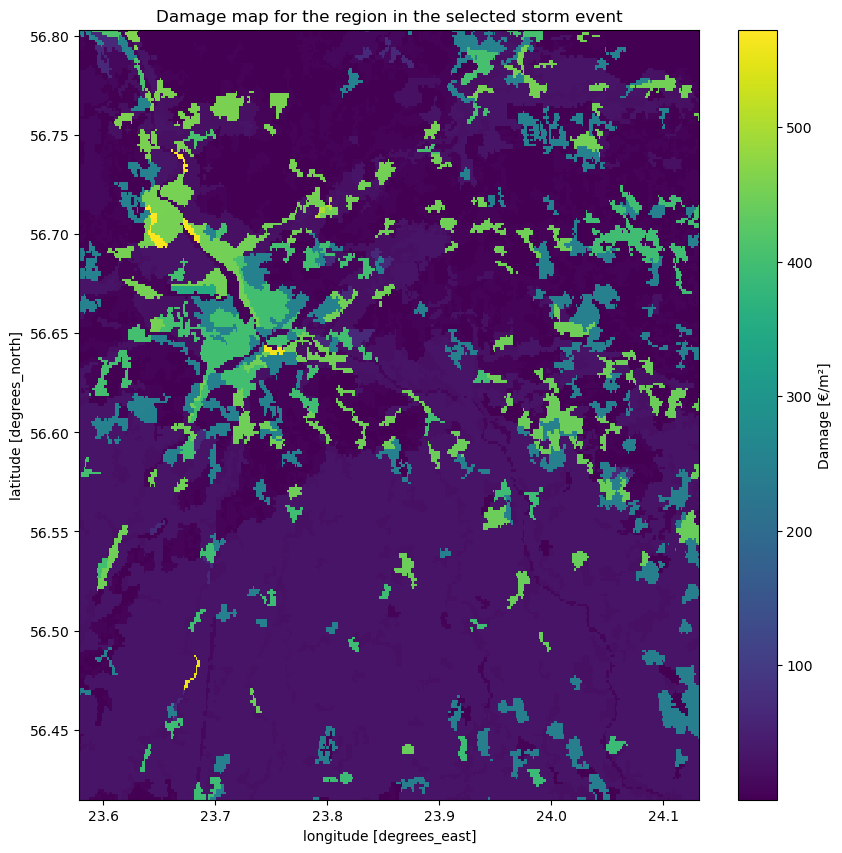

In [179]:
# create figure
fig, ax = plt.subplots(figsize=(10, 10))
damage_map_adjusted.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': "Damage [€/m²]"})
plt.title('Damage map for the region in the selected storm event')

## Conclusions

In this risk assessment workflow we learned how to match event and land cover maps so they can be put into the damagescanner function. We then visualised the damage estimation for a storm. 

## Contributors

**Authors**: 
- Ted Buskop (Deltares & Vrije Universiteit Amsterdam, IVM)

**References**: 

- Koks, E.E., Haer., T. A high-resolution wind damage model for Europe. Sci Rep 10, 6866 (2020). https://doi.org/10.1038/s41598-020-63580-w

- Copernicus Climate Change Service, Climate Data Store, (2022): Winter windstorm indicators for Europe from 1979 to 2021 derived from reanalysis. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.9b4ea013 (Accessed on DD-MMM-YYYY)

- Copernicus Climate Change Service, Climate Data Store, (2022): Synthetic windstorm events for Europe from 1986 to 2011. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.ce973f02 (Accessed on DD-MMM-YYYY)

- Feuerstein, B., Groenemeijer, P., Dirksen, E., Hubrig, M., Holzer, A. M., & Dotzek, N. (2011). Towards an improved wind speed scale and damage description adapted for Central Europe. Atmospheric Research, 100(4), 547-564. https://doi.org/10.1016/j.atmosres.2010.12.026
